# CSE 252B: Computer Vision II, Winter 2019 – Assignment 4
### Instructor: Ben Ochoa
### Due: Wednesday, March 6, 2019, 11:59 PM

## Instructions
* Review the academic integrity and collaboration policies on the course website.
* This assignment must be completed individually.
* This assignment contains both math and programming problems.
* All solutions must be written in this notebook
* Math problems must be done in Markdown/LATEX. Remember to show work and describe your solution.
* Programming aspects of this assignment must be completed using Python in this notebook.
* This notebook contains skeleton code, which should not be modified (This is important for standardization to facilate effeciant grading).
* You may use python packages for basic linear algebra, but you may not use packages that directly solve the problem. Ask the instructor if in doubt.
* You must submit this notebook exported as a pdf. You must also submit this notebook as an .ipynb file.
* You must submit both files (.pdf and .ipynb) on Gradescope. You must mark each problem on Gradescope in the pdf.
* It is highly recommended that you begin working on this assignment early.

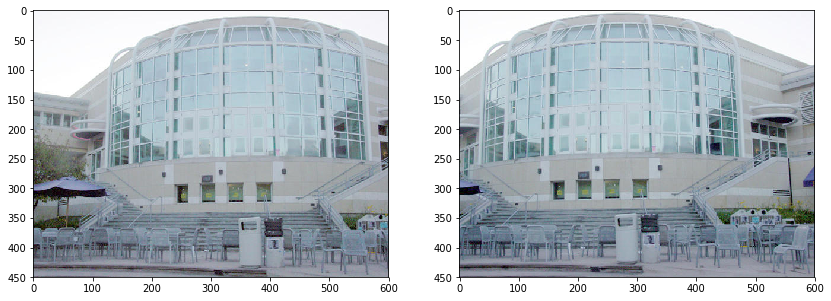

In [1]:
%matplotlib inline
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import time

# open the input images
I1 = np.array(Image.open('price_center20.JPG'), dtype='float')/255.
I2 = np.array(Image.open('price_center21.JPG'), dtype='float')/255.

# Display the input images
plt.figure(figsize=(14,8))
plt.subplot(1,2,1)
plt.imshow(I1)
plt.subplot(1,2,2)
plt.imshow(I2)
plt.show()

## Problem 1 (Programming): Feature detection (20 points)
Download input data from the course website. The file price_center20.JPG
contains image 1 and the file price_center21.JPG contains image 2. 

For each input image, calculate an image where each pixel value is the minor
eigenvalue of the gradient matrix

$N=\left[ \begin{array}{cc}
\sum\limits_w I_x^2 & \sum\limits_w I_x I_y\\
\sum\limits_w I_x I_y & \sum\limits_w I_y^2
\end{array} \right]$

where w is the window about the pixel, and $I_x$ and $I_y$ are the gradient images in
the x and y direction, respectively. Calculate the gradient images using the fivepoint
central difference operator. Set resulting values that are below a specified
threshold value to zero (hint: calculating the mean instead of the sum in N allows
for adjusting the size of the window without changing the threshold value). Apply
an operation that suppresses (sets to 0) local (i.e., about a window) nonmaximum
pixel values in the minor eigenvalue image. Vary these parameters such that
around 600–650 features are detected in each image. For resulting nonzero pixel
values, determine the subpixel feature coordinate using the Forstner corner point
operator.

#### Report your final values for:
 * the size of the feature detection window (i.e. the size of the window used to calculate the elements in the gradient matrix N)
 * the minor eigenvalue threshold value 
 * the size of the local nonmaximum suppression window 
 * the resulting number of features detected (i.e. corners) in each image.

#### Display figures for:
 * original images with detected features


In [2]:
from scipy.ndimage import convolve

def ImageGradient(I, w, t):
    # inputs: 
    # I is the input image (may be mxn for Grayscale or mxnx3 for RGB)
    # w is the size of the window used to compute the gradient matrix N
    # t is the minor eigenvalue threshold
    #
    # outputs:
    # N is the 2x2xmxn gradient matrix
    # b in the 2x1xmxn vector used in the Forstner corner detector
    # J0 is the mxn minor eigenvalue image of N before thresholding
    # J1 is the mxn minor eigenvalue image of N after thresholding
    
    w = int(w/2)
    m,n = I.shape[:2]
    N = np.zeros((2,2,m,n))
    b = np.zeros((2,1,m,n))
    J0 = np.zeros((m,n))
    J1 = np.zeros((m,n))
    
    """your code here"""
    # Change RGB to Gray
    I = np.array(Image.fromarray((I*255).astype('uint8')).convert('L'), dtype = 'float')/255.
    
    # Convolution and preparation for later calculation
    K = 1./12. * np.array([-1., 8., 0., -8., 1.])
    I_x, I_y = I.copy(), I.copy()
    I_xx, I_yy, I_xy = I.copy(),I.copy(),I.copy() # matrix for calculating Gradient matrix
    # matrix for calculating b
    x_I_xx, y_I_yy, x_I_xy, y_I_xy = I.copy(),I.copy(),I.copy(), I.copy()
    for i in range(I.shape[0]):
        I_x[i] = convolve(I[i], K, mode='reflect')
        I_xx[i] = I_x[i]*I_x[i]
    for j in range(I.shape[1]):
        I_y[:,j] = convolve(I[:,j], K, mode='reflect')
        I_yy[:,j] = I_y[:,j]*I_y[:,j]
    I_xy = I_x*I_y
    
    # reduce value smaller than e-10 to 0
    I_xx[I_xx < 10**(-20)] = 0
    I_yy[I_yy < 10**(-20)] = 0
    I_xy[I_xy < 10**(-20)] = 0
    
    for i in range(I.shape[0]):
        for j in range(I.shape[1]):
            x_I_xx[i,j] = j*I_xx[i,j]
            y_I_yy[i,j] = i*I_yy[i,j]
            x_I_xy[i,j] = j*I_xy[i,j]
            y_I_xy[i,j] = i*I_xy[i,j]
    
    # Gradient Image and the b vector for corner detector
    def SingleWindow(i, j):
        g = np.zeros((2,2))
        sb = np.zeros((2,1))
        if i<w or j<w or i+w+1>m or j+w+1>n: return g, sb
        else:
            g[0][0] = I_xx[i-w:i+w+1, j-w:j+w+1].mean()
            g[1][1] = I_yy[i-w:i+w+1, j-w:j+w+1].mean()
            g[0][1] = g[1][0] = I_xy[i-w:i+w+1, j-w:j+w+1].mean()
            sb[0,0] = x_I_xx[i-w:i+w+1, j-w:j+w+1].mean() + \
                                y_I_xy[i-w:i+w+1, j-w:j+w+1].mean()
            sb[1,0] = y_I_yy[i-w:i+w+1, j-w:j+w+1].mean() + \
                                x_I_xy[i-w:i+w+1, j-w:j+w+1].mean()
            return g, sb
        
    for i in range(m):
        for j in range(n):
            N[:,:,i,j], b[:,:,i,j]= SingleWindow(i,j)
    
    # Minor eigen values
    for i in range(m):
        for j in range(n):
            lam = np.min(np.linalg.eigvals(N[:,:,i,j]))
            J0[i,j] = lam
            J1[i,j] = lam if lam>=t else 0.
            
    return N, b, J0, J1
  
  
def NMS(J, w_nms):
    # Apply nonmaximum supression to J using window w
    # For any window in J, the result should only contain 1 nonzero value
    # In the case of multiple identical maxima in the same window,
    # the tie may be broken arbitrarily
    #
    # inputs: 
    # J is the minor eigenvalue image input image after thresholding
    # w_nms is the size of the local nonmaximum suppression window
    # 
    # outputs:
    # J2 is the mxn resulting image after applying nonmaximum suppression
    # 
    
    w_nms=int(w_nms/2)
    J2 = J.copy()
    J_tmp = J.copy()
    m,n = J.shape
    """your code here"""
    for i in range(w_nms, m-w_nms):
        for j in range(w_nms, n-w_nms):
            window = J_tmp[i-w_nms:i+w_nms+1, j-w_nms:j+w_nms+1]
            maximum = np.amax(window)   # find the maximum value in the window
            window[window<maximum]=0   # abandon those smaller than maximum value
            J2[i-w_nms:i+w_nms+1,j-w_nms: j+w_nms+1] = window.copy()
    return J2
  
  
def ForstnerCornerDetector(J, N, b):
    # Gather the coordinates of the nonzero pixels in J 
    # Then compute the sub pixel location of each point using the Forstner operator
    #
    # inputs:
    # J is the NMS image
    # N is the 2x2xmxn gradient matrix
    # b is the 2x1xmxn vector computed in the image_gradient function
    #
    # outputs:
    # C is the number of corners detected in each image
    # pts is the 2xC list of coordinates of subpixel accurate corners
    #     found using the Forstner corner detector
    
    """your code here"""
    m, n = J.shape
    C = 0
    pts = []
    for i in range(m):
        for j in range(n):
            if J[i,j]==0.: continue
            else:
                # solve for x_center, y_center
                p = np.linalg.solve(N[:,:,i,j],b[:,:,i,j]) 
                C+=1
                pts.append(p)
    pts = np.array(pts).T[0]
    return C, pts


# feature detection
def RunFeatureDetection(I, w, t, w_nms):
    N, b, J0, J1 = ImageGradient(I, w, t)
    J2 = NMS(J1, w_nms)
    C, pts = ForstnerCornerDetector(J2, N, b)
    return C, pts, J0, J1, J2


took 38.736453 secs


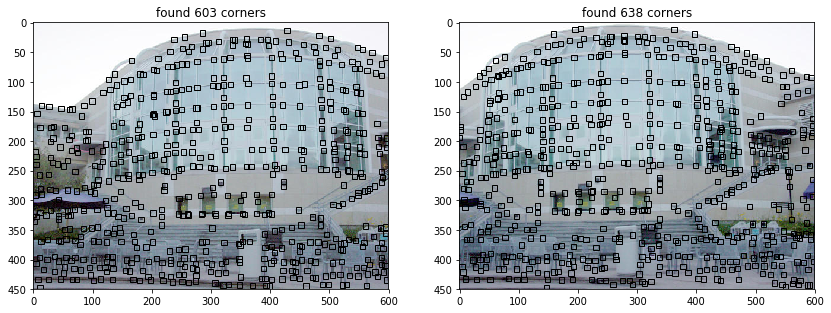

In [3]:
# input images
I1 = np.array(Image.open('price_center20.JPG'), dtype='float')/255.
I2 = np.array(Image.open('price_center21.JPG'), dtype='float')/255.

# parameters to tune
w = 9
t = 0.000135
w_nms = 9

tic = time.time()

# run feature detection algorithm on input images
C1, pts1, J1_0, J1_1, J1_2 = RunFeatureDetection(I1, w, t, w_nms)
C2, pts2, J2_0, J2_1, J2_2 = RunFeatureDetection(I2, w, t, w_nms)
toc = time.time() - tic
print('took %f secs'%toc)

# display results
plt.figure(figsize=(14,24))

# show corners on original images
ax = plt.subplot(1,2,1)
plt.imshow(I1)
for i in range(C1): # draw rectangles of size w around corners
    x,y = pts1[:,i]
    ax.add_patch(patches.Rectangle((x-w/2,y-w/2),w,w, fill=False))
# plt.plot(pts1[0,:], pts1[1,:], '.b') # display subpixel corners
plt.title('found %d corners'%C1)

ax = plt.subplot(1,2,2)
plt.imshow(I2)
for i in range(C2):
    x,y = pts2[:,i]
    ax.add_patch(patches.Rectangle((x-w/2,y-w/2),w,w, fill=False))
# plt.plot(pts2[0,:], pts2[1,:], '.b')
plt.title('found %d corners'%C2)

plt.show()

#### Final values for parameters
* w = 9
* t = 0.000135
* w_nms = 9
* C1 = 603
* C2 = 638

## Problem 2 (Programming): Feature matching (15 points)
Determine the set of one-to-one putative feature correspondences by performing
a brute-force search for the greatest correlation coefficient value (in the range
[-1, 1]) between the detected features in image 1 and the detected features in
image 2. Only allow matches that are above a specified correlation coefficient
threshold value (note that calculating the correlation coefficient allows for adjusting
the size of the matching window without changing the threshold value).
Further, only allow matches that are above a specified distance ratio threshold
value, where distance is measured to the next best match for a given feature.
Vary these parameters such that around 200 putative feature correspondences are
established. Optional: constrain the search to coordinates in image 2 that are
within a proximity of the detected feature coordinates in image 1.

#### Report your final values for:
* the size of the matching window
* the correlation coefficient threshold
* the distance ratio threshold 
* the size of the proximity window (if used)
* the resulting number of putative feature correspondences (i.e. matched features)

#### Display figures for:
* pair of images, where the matched features in each of the images are indicated by a square window about the feature and a line segment is drawn from the feature to the coordinates of the corresponding feature in the other image



In [4]:
from math import *
def NCC(I1, I2, pts1, pts2, w, p):
    # compute the normalized cross correlation between image patches I1, I2
    # result should be in the range [-1,1]
    #
    # inputs:
    # I1, I2 are the input images
    # pts1, pts2 are the point to be matched
    # w is the size of the matching window to compute correlation coefficients
    # p is the size of the proximity window
    #
    # output:
    # normalized cross correlation matrix of scores between all windows in 
    #    image 1 and all windows in image 2
    
    """your code here"""
    w = int(w/2)
    # Change RGB to gray
    I1 = np.array(Image.fromarray((I1*255).astype('uint8')).convert('L'), \
                  dtype = 'float')/255.
    I2 = np.array(Image.fromarray((I2*255).astype('uint8')).convert('L'), \
                  dtype = 'float')/255.
        
    # Calculation of NCC between two windows
    def ncc(w1,w2):
        w1 = np.array(w1 - w1.mean())
        w2 = np.array(w2 - w2.mean())
        corr = (w1*w2).sum() / sqrt((w1*w1).sum() * (w2*w2).sum());
        return corr

    m,n = I1.shape[:2]
    score = np.zeros((pts1.shape[1],pts2.shape[1]))
    for i in range(pts1.shape[1]):
        for j in range(pts2.shape[1]):
            x1, y1 = int((pts1[1,i])), int((pts1[0,i]))
            x2, y2 = int((pts2[1,j])), int((pts2[0,j]))
            if x1-w<0 or x2-w<0 or y1-w<0 or y2-w<0: 
                score[i,j] = -1
            elif x1+w+1>m or x2+w+1>m or y1+w+1>n or y2+w+1>n: 
                score[i,j] = -1
            else:
                score[i,j] = ncc(I1[x1-w:x1+w+1,y1-w:y1+w+1],\
                                    I2[x2-w:x2+w+1,y2-w:y2+w+1])
    return score


def Match(scores, t, d):
    # perform the one-to-one correspondence matching on the correlation coefficient matrix
    # 
    # inputs:
    # scores is the NCC matrix
    # t is the correlation coefficient threshold
    # d distance ration threshold
    #
    # output:
    # list of the feature coordinates in image 1 and image 2 
    
    """your code here"""
    mask = np.ones((pts1.shape[1],pts2.shape[1]))
    
    pair1 = []
    pair2 = []
    temp_scores = np.multiply(mask,scores)
    while t<np.max(temp_scores):
        max_index = np.argmax(temp_scores)
        max_corr = np.max(temp_scores)
        row = int(max_index/pts2.shape[1])
        col = int(max_index%pts2.shape[1])
        scores[row,col] = -1
        max_next = max([scores[row,:].max(),scores[:,col].max()])
        scores[row,col] = max_corr
        if (1-scores[row,col])<((1-max_next)*d):
            if sqrt(np.square(pts1[0,row]-pts2[0,col])+np.square(pts1[1,row]-pts2[1,col]))<p:
                pair1.append(row)
                pair2.append(col)
        mask[row,:] = np.zeros((1,pts2.shape[1]))
        mask[:,col] = np.zeros((1,pts1.shape[1]))
        temp_scores = np.multiply(mask,temp_scores)
    
    inds = np.array([pair1,pair2])
    
    return inds

def RunFeatureMatching(I1, I2, pts1, pts2, w, t, d, p):
    # inputs:
    # I1, I2 are the input images
    # pts1, pts2 are the point to be matched
    # w is the size of the matching window to compute correlation coefficients
    # t is the correlation coefficient threshold
    # d distance ration threshold
    # p is the size of the proximity window
    #
    # outputs:
    # inds is a 2xk matrix of matches where inds[0,i] indexs a point pts1 
    #     and inds[1,i] indexs a point in pts2, where k is the number of matches
    
    scores = NCC(I1, I2, pts1, pts2, w, p)
    inds = Match(scores, t, d) 
    return inds



took 11.775545 secs


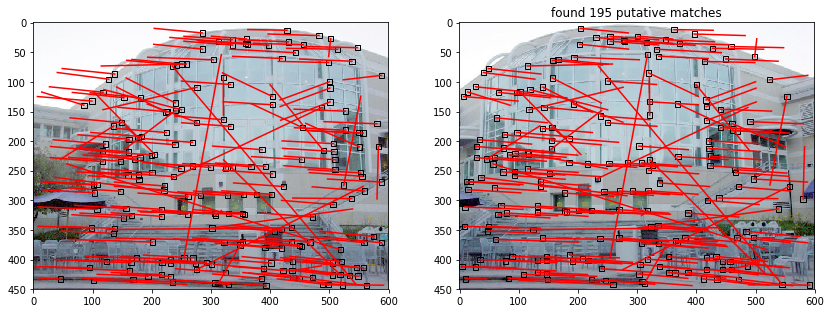

unique points in image 1: 195
unique points in image 2: 195


In [5]:
# parameters to tune

w = 9
t = 0.3
d = 0.85
p = np.inf

tic = time.time()
# run the feature matching algorithm on the input images and detected features
inds = RunFeatureMatching(I1, I2, pts1, pts2, w, t, d, p)
toc = time.time() - tic

print('took %f secs'%toc)

# create new matrices of points which contain only the matched features 
match1 = pts1[:,inds[0,:]]
match2 = pts2[:,inds[1,:]]

# # display the results
plt.figure(figsize=(14,24))
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)
ax1.imshow(I1)
ax2.imshow(I2)
plt.title('found %d putative matches'%match1.shape[1])
for i in range(match1.shape[1]):
    x1,y1 = match1[:,i]
    x2,y2 = match2[:,i]
    ax1.plot([x1, x2],[y1, y2],'-r')
    ax1.add_patch(patches.Rectangle((x1-w/2,y1-w/2),w,w, fill=False))
    ax2.plot([x2, x1],[y2, y1],'-r')
    ax2.add_patch(patches.Rectangle((x2-w/2,y2-w/2),w,w, fill=False))

plt.show()

print('unique points in image 1: %d'%np.unique(inds[0,:]).shape[0])
print('unique points in image 2: %d'%np.unique(inds[1,:]).shape[0])

#### Final values for parameters
* w = 9
* t = 0.3
* d = 0.85
* p = np.inf
* num_matches = 195

## Problem 3 (Programming): Outlier Rejection (15 points)
The resulting set of putative point correspondences should contain both inlier
and outlier correspondences (i.e., false matches). Determine the set of inlier point
correspondences using the M-estimator Sample Consensus (MSAC) algorithm,
where the maximum number of attempts to find a consensus set is determined
adaptively. For each trial, you must use the 4-point algorithm (as described in
lecture) to estimate the planar projective transformation from the 2D points in
image 1 to the 2D points in image 2. Calculate the (squared) Sampson error as a
first order approximation to the geometric error.

hint: this problem has codimension 2

#### Report your values for:
 * the probability $p$ that as least one of the random samples does not contain any outliers
 * the probability $\alpha$ that a given point is an inlier
 * the resulting number of inliers
 * the number of attempts to find the consensus set
 * the tolerance for inliers
 * the cost threshold
 
#### Display figures for:
* pair of images, where the inlier features in each of the images are indicated by a square window about the feature and a line segment is drawn from the feature to the coordinates of the corresponding feature in the other image


took 0.095744 secs
14 iterations
inlier count:  143
inliers:  [0, 2, 3, 4, 5, 6, 7, 9, 11, 12, 13, 14, 16, 18, 19, 21, 23, 24, 25, 27, 28, 30, 32, 34, 35, 36, 37, 38, 39, 40, 41, 42, 44, 45, 46, 47, 48, 49, 50, 51, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 80, 81, 82, 84, 85, 86, 88, 90, 91, 92, 93, 95, 96, 97, 98, 100, 101, 102, 103, 104, 105, 106, 107, 108, 110, 112, 113, 114, 115, 116, 117, 118, 120, 121, 123, 124, 125, 126, 127, 128, 129, 130, 132, 134, 135, 136, 137, 138, 139, 141, 142, 143, 145, 146, 148, 149, 152, 153, 154, 155, 156, 160, 161, 162, 164, 165, 166, 167, 172, 175, 177, 178, 179, 180, 183, 185, 187, 188]
MSAC Cost=373.221675695
H_MSAC = 
[[ 1.09769833e-02  2.15919571e-06 -9.86718277e-01]
 [ 3.07563747e-04  1.06582895e-02 -1.61392949e-01]
 [ 1.23033726e-06  5.82872090e-08  1.02552088e-02]]


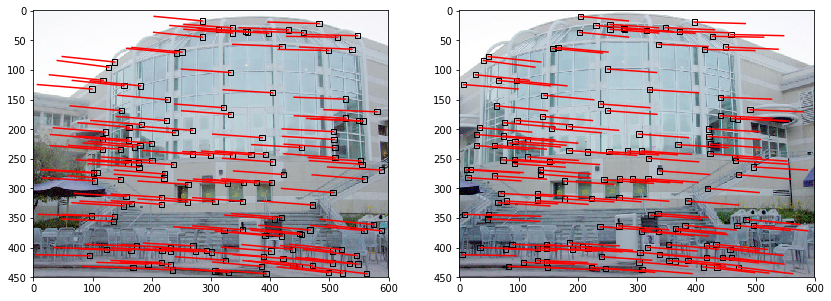

In [6]:
from scipy.stats import chi2
import random

def Homogenize(x):
    # converts points from inhomogeneous to homogeneous coordinates
    return np.vstack((x,np.ones((1,x.shape[1]))))

def Dehomogenize(x):
    # converts points from homogeneous to inhomogeneous coordinates
    return x[:-1]/x[-1]

# Checked
def get_H_inv(pts, choice):
    A = np.hstack((Homogenize(pts[:,choice[0]].reshape(2,1)),\
                   Homogenize(pts[:,choice[1]].reshape(2,1)),\
                  Homogenize(pts[:,choice[2]].reshape(2,1))))
    y = Homogenize(pts[:,choice[3]].reshape(2,1))
    lambdas = np.linalg.inv(A).dot(y)
    H_inv = np.hstack((lambdas[0]*Homogenize(pts[:,choice[0]].reshape(2,1)),\
                       lambdas[1]*Homogenize(pts[:,choice[1]].reshape(2,1)),\
                      lambdas[2]*Homogenize(pts[:,choice[2]].reshape(2,1))))
    return H_inv

# Checked
def transform_H(pts1, pts2, choice):
    H1_inv = get_H_inv(pts1, choice)
    H2_inv = get_H_inv(pts2, choice)
    H = H2_inv.dot(np.linalg.inv(H1_inv))
    return H

# Checked
def Sampson_error(pts1, pts2, H):
    error_vec = []
    Sampson_vec = []
    for i in range(pts1.shape[1]):
        x1 = pts1[0,i]
        x2 = pts2[0,i]
        y1 = pts1[1,i]
        y2 = pts2[1,i]
        
        A = np.array([[0,0,0,-x1,-y1,-1,y2*x1,y2*y1,y2],\
                      [x1,y1,1,0,0,0,-x2*x1,-x2*y1,-x2]])
        h = np.vstack((H[0,:].reshape(3,1),H[1,:].reshape(3,1),H[2,:].reshape(3,1)))
        e = A.dot(h)
        J = np.array([[-H[1,0]+y2*H[2,0],-H[1,1]+y2*H[2,1],0,x1*H[2,0]+y1*H[2,1]+H[2,2]],\
                      [H[0,0]-x2*H[2,0],H[0,1]-x2*H[2,1],-(x1*H[2,0]+y1*H[2,1]+H[2,2]),0]])
        lambda_s = np.linalg.inv(J.dot(J.T)).dot(-e)
        delta = J.T.dot(lambda_s)
        Sampson_vec.append(delta)
        error = delta.T.dot(delta)
        error_vec.append(error)
    return error_vec,np.array(Sampson_vec).reshape(pts1.shape[1],delta.shape[0]).T

# Checked
def consensus_cost(error,tol):
    cost = 0
    num_inlier = 0
    inliers = []
    for i in range(len(error)):
        if error[i]<=tol:
            cost = cost+error[i]
            num_inlier = num_inlier+1
            inliers.append(i)
        else:
            cost = cost+tol
    return cost,num_inlier,inliers

# Checked
def MSAC(pts1, pts2, thresh, tol, p, alpha):
    # Inputs:
    #    pts1 - matched feature correspondences in image 1
    #    pts2 - matched feature correspondences in image 2
    #    thresh - cost threshold
    #    tol - reprojection error tolerance 
    #    p - probability that as least one of the random samples does not contain any outliers   
    #
    # Output:
    #    consensus_min_cost - final cost from MSAC
    #    consensus_min_cost_model - planar projective transformation matrix H
    #    inliers - list of indices of the inliers corresponding to input data
    #    trials - number of attempts taken to find consensus set
    
    """your code here"""
    trials = 0
    max_trials = np.inf
    consensus_min_cost = np.inf
    while trials < max_trials and consensus_min_cost>thresh:
        samples = random.sample(range(pts1.shape[1]),4)
        H = transform_H(pts1, pts2, samples)
        error,Sampson_vec = Sampson_error(pts1, pts2, H)
        cost,num_inlier,inliers = consensus_cost(error,tol)
        if cost<consensus_min_cost:
            consensus_min_cost = cost
            consensus_min_cost_model = H
            # update max_trials
            ww = float(num_inlier)/float(pts1.shape[1])
            if ww>0:
                max_trials = np.log(1-p)/np.log(1-ww**4)  
        trials = trials+1
    
    error,Sampson_vec = Sampson_error(pts1, pts2, consensus_min_cost_model)
    consensus_min_cost,num_inlier,inliers = consensus_cost(error,tol)
    consensus_min_cost_model/=np.linalg.norm(consensus_min_cost_model)
    return consensus_min_cost, consensus_min_cost_model, inliers, trials


# MSAC parameters 
thresh = 0
tol = 5.9915
p = 0.99
alpha = 0.95

tic=time.time()

cost_MSAC, H_MSAC, inliers, trials = MSAC(match1, match2, thresh, tol, p, alpha)
# choose just the inliers
x1 = match1[:,inliers]
x2 = match2[:,inliers]
outliers = np.setdiff1d(np.arange(pts1.shape[1]),inliers)

toc=time.time()
time_total=toc-tic

# display the results
print('took %f secs'%time_total)
print('%d iterations'%trials)
print('inlier count: ',len(inliers))
print('inliers: ',inliers)
print('MSAC Cost=%.9f'%cost_MSAC)
print('H_MSAC = ')
print(H_MSAC)

# display the figures
"""your code here"""
plt.figure(figsize=(14,8))
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)
ax1.imshow(I1)
ax2.imshow(I2)
for i in range(x1.shape[1]):
    ii = inds[0,inliers[i]]
    jj = inds[1,inliers[i]]
    x1_x, x1_y = pts1[0,ii], pts1[1,ii]
    x2_x, x2_y = pts2[0,jj], pts2[1,jj]
    ax1.plot([x1_x, x2_x],[x1_y, x2_y],'-r')
    ax1.add_patch(patches.Rectangle((x1_x-w/2,x1_y-w/2),w,w, fill=False))
    ax2.plot([x2_x, x1_x],[x2_y, x1_y],'-r')
    ax2.add_patch(patches.Rectangle((x2_x-w/2,x2_y-w/2),w,w, fill=False))
plt.show()

#### Final values for parameters
* $p$ = 0.99
* $\alpha$ = 0.95
* tolerance = 5.9915
* threshold = 0
* num_inliers = 142
* num_attempts = 14

## Problem 4 (Programming): Linear Estimate (15 points)
  Estimate the planar projective transformation $\boldsymbol{H}_\text{DLT}$
  from the resulting set of inlier correspondences using the direct
  linear transformation (DLT) algorithm (with data normalization).
  You must express $\boldsymbol{x}'_i = \boldsymbol{H} \boldsymbol{x}_i$ as
  $[\boldsymbol{x}'_i]^\perp \boldsymbol{H} \boldsymbol{x}_i = \boldsymbol{0}$ (not
  $\boldsymbol{x}'_i \times \boldsymbol{H} \boldsymbol{x}_i = \boldsymbol{0}$), where
  $[\boldsymbol{x}'_i]^\perp \boldsymbol{x}'_i = \boldsymbol{0}$, when forming the
  solution. Return $\boldsymbol{H}_\text{DLT}$, scaled such that
  $||\boldsymbol{H}_\text{DLT}||_\text{Fro} = 1$

In [7]:
def Sinc(x):
    """your code here"""
    if x==0: 
        y=1
    else: 
        y = np.sin(x)/float(x)
    return y

def dSinc(x):
    # Returns a scalar valued sinc value
    if x==0: y=0
    else: y = np.cos(x)/x - np.sin(x)/(x**2)
    return y

# Checked
def Normalize(pts):
    # data normalization of n dimensional pts
    #
    # Input:
    #    pts - is in inhomogeneous coordinates
    # Outputs:
    #    pts - data normalized points
    #    T - corresponding transformation matrix
    """your code here"""
    n, m = pts.shape[0], pts.shape[1]
    u = [x.mean() for x in pts] # mean values of each dimensino
    d = [(np.std(x))**2 for x in pts] # deviation of each dimensino
    s = (n/sum(d))**0.5  # scale
    T = np.eye(n+1)
    T[:n, :n] = np.eye(n)*s
    T[:n,-1] = np.array(u)*(-1)*s  # Transform matrix
    pts = Homogenize(pts) 
    pts = np.array([T*np.mat(pts[:,i]).T for i in range(m)])
    pts = pts.reshape(m,n+1).T
    return pts, T

# Checked
def LeftNullVector(x):
    # compute left null of x
    e = np.array([1]+[0]*(x.shape[1]-1))
    V = [np.mat(a + np.linalg.norm(a)*e) if a[0]>0 \
         else np.mat(a - np.linalg.norm(a)*e) \
         for a in x]
    I = np.eye(x.shape[1])
    H = np.array([I-2*(v.T*v)/(v*v.T) for v in V])
    return H[:,1:,:]

# Checked
def Parameterization(v):
    v = v/np.linalg.norm(v)
    a = v[0,0]
    b = v[1:]
    v_i = 2.0/Sinc(np.arccos(a))*b
    
    if np.linalg.norm(v_i)>np.pi:
        v_i = (1-2.0*np.pi/np.linalg.norm(v_i)*\
               np.ceil((np.linalg.norm(v_i)-np.pi)/(2.0*np.pi)))*v_i
    return v_i.reshape(b.shape[0],1)

# Checked
def Sampson_correction(pts,Sampson_vec):
    pts_para = []
    pts_depara = []
    for i in range(pts.shape[1]):
        x1 = pts[0,i]+Sampson_vec[0,i]
        y1 = pts[1,i]+Sampson_vec[1,i]
        v = Homogenize(np.array([x1,y1]).reshape(2,1))
        v = v/np.linalg.norm(v)
        pts_para.append(Parameterization(v))
        pts_depara.append(Dehomogenize(v))
    return np.array(pts_para).reshape(pts.shape[1],2).T,\
            np.array(pts_depara).reshape(pts.shape[1],2).T

def projection(x,H):
    return Dehomogenize(H.dot(Homogenize(x)))

def DLT(x1, x2, normalize=True):
    """your code here"""
    # Inputs:
    #    x1 - inhomogeneous inlier correspondences in image 1
    #    x2 - inhomogeneous inlier correspondences in image 1
    #    normalize - if True, apply data normalization to x1 and x2
    #
    # Outputs:
    #    H - the DLT estimate of the planar projective transformation   
    #    cost - linear estimate cost
    # data normalization
    if normalize:
        print('normalize')
        x1_normalized_homo,T = Normalize(x1)
        x2_normalized_homo,U = Normalize(x2)
        x1_normalized = Dehomogenize(x1_normalized_homo)
        x2_normalized = Dehomogenize(x2_normalized_homo)
        s_1 = T[0,0]**2
        s_2 = U[0,0]**2
        sigma_1 = s_1*np.eye(2)
        sigma_2 = s_2*np.eye(2)
    # data denormalize
    if not normalize:
        print('denormalize')
        x1_normalized_homo = Homogenize(x1)
        x2_normalized_homo = Homogenize(x2)
        x1_normalized = x1.copy()
        x2_normalized = x2.copy()
        s_1 = 1
        s_2 = 1
        sigma_1 = s_1*np.eye(2)
        sigma_2 = s_2*np.eye(2)
    
    #DLT calculation
    A = np.zeros((1,9))
    e = np.zeros((3,1))
    x2_ = LeftNullVector(x2_normalized_homo.T)
    A = np.array([np.kron(x2_[i],x1_normalized_homo[:,i]) \
                  for i in range(x1_normalized_homo.shape[1])])
    A = A.reshape((A.shape[0]*A.shape[1],1, A.shape[2]))
    A = A.reshape((A.shape[0], A.shape[2]))
    _, _, V = np.linalg.svd(A[1:,:], full_matrices=False)
    H = np.array([V[8,0:3],V[8,3:6],V[8,6:]])
    H = H/np.linalg.norm(H)
    
    #calculate the LM cost
    error,Sampson_vec = Sampson_error(x1_normalized, x2_normalized, H)
    pts_scene_par, pts_scene = Sampson_correction(x1_normalized,Sampson_vec)
    cost = 0
    for i in range(x1.shape[1]):
        e_i = x1_normalized[:,i].reshape(2,1) - pts_scene[:,i].reshape(2,1)
        e_i_prime = x2_normalized[:,i].reshape(2,1) - \
                        projection(pts_scene[:,i].reshape(2,1),H)
        cost = cost + e_i.T.dot(np.linalg.inv(sigma_1)).dot(e_i)+\
            e_i_prime.T.dot(np.linalg.inv(sigma_2)).dot(e_i_prime)
        
    if normalize:
        H = np.linalg.inv(U).dot(H).dot(T)
    H = H/(np.linalg.norm(H) * np.sign(H[-1,-1]))
    return H, cost

# compute the linear estimate without data normalization
print ('Running DLT without data normalization')
time_start=time.time()
H_DLT, cost = DLT(x1, x2, normalize=False)
time_total=time.time()-time_start
# display the results
print('took %f secs'%time_total)
print('Cost=%.9f'%cost)


# compute the linear estimate with data normalization
print ('Running DLT with data normalization')
time_start=time.time()
H_DLT, cost = DLT(x1, x2, normalize=True)
time_total=time.time()-time_start
# display the results
print('took %f secs'%time_total)
print('Cost=%.9f'%cost)

Running DLT without data normalization
denormalize
took 0.030917 secs
Cost=44.084329186
Running DLT with data normalization
normalize
took 0.026928 secs
Cost=42.395104178


In [8]:
# display your H_DLT, scaled with its frobenius norm
print('H_DLT = ',H_DLT)

H_DLT =  [[ 1.09788533e-02 -1.85446241e-05 -9.85144252e-01]
 [ 3.10657437e-04  1.06828057e-02 -1.70737039e-01]
 [ 1.23902469e-06  5.70766072e-08  1.02426572e-02]]


## Problem 5 (Programming): Nonlinear Estimate (45 points) 
 Use $\boldsymbol{H}_\text{DLT}$ and the Sampson corrected points (in image 1) as an initial estimate to an iterative estimation method,
  specifically the sparse Levenberg-Marquardt algorithm, to
  determine the Maximum Likelihood estimate of the planar projective
  transformation that minimizes the reprojection error.  You must
  parameterize the planar projective transformation matrix and the
  homogeneous 2D scene points that are being adjusted using the
  parameterization of homogeneous vectors (see section A6.9.2 (page 624) of the textbook, and the corrections and errata).
  
  Report the initial cost (i.e. cost at iteration 0) and the cost at the end
  of each successive iteration. Show the numerical values for the final 
  estimate of the planar projective transformation matrix $\boldsymbol{H}_\text{LM}$, scaled
  such that $||\boldsymbol{H}_\text{LM}||_\text{Fro} = 1$.

In [12]:
from scipy.linalg import block_diag

def parameterize_prime(v):
    pprime = np.zeros((v.shape[0]+1,v.shape[0]))
    b = Sinc(np.linalg.norm(v)/2.0)/2.0*v
    if np.linalg.norm(v) == 0:
        pprime[1:,:] = 0.5*np.identity(v.shape[0])
    else:
        pprime[0,:] = -1.0/2*b.T
        pprime[1:,:] = Sinc(np.linalg.norm(v)/2.0)/2.0*np.identity(v.shape[0])+\
        1.0/(4*np.linalg.norm(v))*dSinc(np.linalg.norm(v)/2.0)*np.dot(v,v.T)
    
    return pprime

def dxprime_dh(x,x_prime,H):
    w_prime = H[2,:].reshape(1,3).dot(Homogenize(x))
    xprime_h = 1.0/w_prime*np.array\
    ([[x[0,0],x[1,0],1,0,0,0,-x_prime[0,0]*x[0,0],-x_prime[0,0]*x[1,0],-x_prime[0,0]],\
    [0,0,0,x[0,0],x[1,0],1,-x_prime[1,0]*x[0,0],-x_prime[1,0]*x[1,0],-x_prime[1,0]]])
    return xprime_h

def dxprime_dx(x,x_prime,H):
    w_prime = H[2,:].reshape(1,3).dot(Homogenize(x))
    xprime_x = 1.0/w_prime*np.array([[H[0,0]-x_prime[0,0]*H[2,0],\
                                      H[0,1]-x_prime[0,0]*H[2,1],\
                                      H[0,2]-x_prime[0,0]*H[2,2]],\
                                     [H[1,0]-x_prime[1,0]*H[2,0],\
                                      H[1,1]-x_prime[1,0]*H[2,1],\
                                      H[1,2]-x_prime[1,0]*H[2,2]]])
    return xprime_x

def Jacobian(pts1,pts2,pts_scene_para,pts_scene,H,h_para):
    A = dxprime_dh(pts_scene,pts2,H).dot(parameterize_prime(h_para))
    v = parameterize_prime(pts_scene_para)
    B = dxprime_dx(pts_scene,pts1,H).dot(v)
    B_prime = dxprime_dx(pts_scene,pts2,H).dot(v)
    return A,B,B_prime

def Deparameterization(v):
    if np.linalg.norm(v)>np.pi:
        v = (1-2.0*np.pi/np.linalg.norm(v)*\
             np.ceil((np.linalg.norm(v)-np.pi)/(2.0*np.pi)))*v
    a = np.cos(np.linalg.norm(v)/2.0)
    b = Sinc(np.linalg.norm(v)/2.0)/2.0*v
    return np.vstack((a,b))

def LM(H, x1, x2, max_iters, lam):
    # Input:
    #    H - DLT estimate of planar projective transformation matrix
    #    x1 - inhomogeneous inlier points in image 1
    #    x2 - inhomogeneous inlier points in image 2
    #    max_iters - maximum number of iterations
    #    lam - lambda parameter
    # Output:
    #    H - Final H (3x3) obtained after convergence
       
    """your code here"""
    
    # data denormalization
    x1_normalized_homo,T = Normalize(x1)
    x2_normalized_homo,K = Normalize(x2)
    s_1 = T[0,0]**2
    s_2 = K[0,0]**2
    sigma_1 = s_1*np.eye(2)
    sigma_2 = s_2*np.eye(2)
    x1_normalized = Dehomogenize(x1_normalized_homo)
    x2_normalized = Dehomogenize(x2_normalized_homo)
    H = K.dot(H).dot(np.linalg.inv(T))
    
    #get the scene points
    error,Sampson_vec = Sampson_error(x1_normalized, x2_normalized, H)
    pts_scene_para,pts_scene = Sampson_correction(x1_normalized,Sampson_vec)
    
    pts_scene_vec_best = pts_scene
    pts_scene_para_vec_best = pts_scene_para
    
    h = np.vstack((H[0,:].reshape(3,1),H[1,:].reshape(3,1),H[2,:].reshape(3,1)))
    h_para = Parameterization(h)      
    
    U = np.zeros((8,8))
    e_a_prime = np.zeros((8,1))
    V_i = []
    W_i = []
    e_bi = []
    cost = 0
    #get the normal equations matrix
    for i in range(x1.shape[1]):
        A,B,B_prime = Jacobian(x1_normalized[:,i].reshape(2,1),x2_normalized[:,i].reshape(2,1),\
                               pts_scene_para[:,i].reshape(2,1),pts_scene[:,i].reshape(2,1),H,h_para)
        U = U + A.T.dot(np.linalg.inv(sigma_2)).dot(A)
        V_i.append(B.T.dot(np.linalg.inv(sigma_1)).dot(B)+\
                   B_prime.T.dot(np.linalg.inv(sigma_2)).dot(B_prime))
        W_i.append(A.T.dot(np.linalg.inv(sigma_2)).dot(B_prime))
        e_i = x1_normalized[:,i].reshape(2,1) - pts_scene[:,i].reshape(2,1)
        e_i_prime = x2_normalized[:,i].reshape(2,1) - \
                    projection(pts_scene[:,i].reshape(2,1),H)
        cost = cost + e_i.T.dot(np.linalg.inv(sigma_1)).dot(e_i) + \
                        e_i_prime.T.dot(np.linalg.inv(sigma_2)).dot(e_i_prime)
        e_a_prime = e_a_prime + A.T.dot(np.linalg.inv(sigma_2)).dot(e_i_prime)
        e_bi.append(B.T.dot(np.linalg.inv(sigma_1)).dot(e_i)+\
                    B_prime.T.dot(np.linalg.inv(sigma_2)).dot(e_i_prime))
    
    #LM loop
    iter_num = 0
    count = 0
    flag = True
    while(flag and iter_num<max_iters):
        S = np.zeros((8,8))
        e = np.zeros((8,1))
        for j in range(x1_normalized.shape[1]):
            S = S - W_i[j].dot(np.linalg.inv(V_i[j]+lam*np.eye(2))).dot(W_i[j].T)
            e = e - W_i[j].dot(np.linalg.inv(V_i[j]+lam*np.eye(2))).dot(e_bi[j])
        S = S + U + lam*np.identity(U.shape[0])
        e = e + e_a_prime
        delta_a_prime = np.linalg.inv(S).dot(e)
        h_para_temp = h_para + delta_a_prime
        H_temp = Deparameterization(h_para_temp).reshape(3,3)
        cost_temp = 0
        pts_scene_tem_vec = []
        pts_scene_vec = []
        pts_scene_para_vec = []
        for i in range(x1.shape[1]):
            delta_bi = (np.linalg.inv(V_i[i]+lam*np.identity(V_i[i].shape[0])))\
                        .dot(e_bi[i]-W_i[i].T.dot(delta_a_prime))
            pts_scene_tem_para = pts_scene_para[:,i].reshape(2,1) + delta_bi
            pts_scene_tem_depara = Dehomogenize(Deparameterization(pts_scene_tem_para))
            pts_scene_vec.append(pts_scene_tem_depara)
            pts_scene_para_vec.append(pts_scene_tem_para)
            e_i_temp = x1_normalized[:,i].reshape(2,1) - pts_scene_tem_depara
            e_i_prime_temp = x2_normalized[:,i].reshape(2,1) - \
                                projection(pts_scene_tem_depara,H_temp)
            cost_temp = cost_temp + e_i_temp.T.dot(np.linalg.inv(sigma_1)).dot(e_i_temp) + \
            e_i_prime_temp.T.dot(np.linalg.inv(sigma_2)).dot(e_i_prime_temp)
        
        if cost_temp>cost:
            lam = 10*lam
            continue
        H = H_temp
        lam = lam*0.1
        if abs(cost_temp-cost)<0.0000000000000000000001: count+=1
        if count>5: flag=False
        cost = cost_temp
        iter_num+=1
        print ('iter %03d Cost %.9f'%(iter_num, cost))
    H = np.linalg.inv(K).dot(H).dot(T)
    H = H/np.sqrt(np.sum(H**2))
    return H


# LM hyperparameters
lam = .001
max_iters = 100

# Run LM initialized by DLT estimate with data normalization
print ('Running sparse LM with data normalization')
print ('iter %03d Cost %.9f'%(0, cost))
time_start=time.time()
H_LM = LM(H_DLT, x1, x2, max_iters, lam)
time_total=time.time()-time_start
print('took %f secs'%time_total)

Running sparse LM with data normalization
iter 000 Cost 42.395104178
(2, 143)
(3, 1)
iter 001 Cost 42.389880439
iter 002 Cost 42.389880439
iter 003 Cost 42.389880439
iter 004 Cost 42.389880439
iter 005 Cost 42.389880439
iter 006 Cost 42.389880439
iter 007 Cost 42.389880439
took 0.390946 secs


In [19]:
# display your converged H_LM, scaled with its frobenius norm
print('H_LM = ',H_LM)


H_LM =  [[ 1.09718521e-02 -1.85477084e-05 -9.85081196e-01]
 [ 3.13895819e-04  1.06712816e-02 -1.71102449e-01]
 [ 1.24479971e-06  6.29138536e-08  1.02290258e-02]]
